In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import nltk
import mlflow
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

import re
import time
from gensim.models import Word2Vec, FastText
from gensim.models import KeyedVectors
from transformers import BertTokenizer, TFBertModel

import tensorflow_hub as hub

import pickle
import requests
import zipfile
import os

import mlflow


2024-11-17 15:12:09.492860: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 15:12:09.496051: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 15:12:09.504340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731856329.519186  813585 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731856329.523689  813585 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 15:12:09.536390: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
import numpy
import tensorflow
import gensim
import numba
print("Numpy version:", numpy.__version__)
print("TensorFlow version:", tensorflow.__version__)
print("Gensim version:", gensim.__version__)
print("Numba version:", numba.__version__)


Numpy version: 1.26.4
TensorFlow version: 2.18.0
Gensim version: 4.3.3
Numba version: 0.60.0


In [3]:
import os

# Définir un nouveau répertoire de suivi, par exemple, un dossier spécifique pour les expériences MLflow
tracking_dir = "/tmp/mlruns"  # Vous pouvez choisir un autre répertoire si nécessaire
os.makedirs(tracking_dir, exist_ok=True)  # Crée le dossier s'il n'existe pas

#mlflow.set_tracking_uri(f"file://{tracking_dir}")
mlflow.set_tracking_uri("http://mlflow-server:5000")


In [4]:
# Recharger le DataFrame depuis le fichier pickle
df = pd.read_pickle('download/df_sample_20000.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 367103 to 839590
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  20000 non-null  int64 
 1   ids     20000 non-null  int64 
 2   date    20000 non-null  object
 3   flag    20000 non-null  object
 4   user    20000 non-null  object
 5   text    20000 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


In [5]:
 #Vérifier si le DataFrame a au moins 16 000 lignes
if len(df) != 20000:
    raise ValueError("Le DataFrame ne contient pas de 20 000 lignes.")

# # Calculer la proportion nécessaire pour obtenir 16 000 lignes
# sample_size = 16000 / len(df_sample)

# # Utiliser train_test_split pour sélectionner un échantillon équilibré de 16 000 lignes
# df_16000, _ = train_test_split(df_sample, train_size=sample_size, stratify=df_sample['target'], random_state=42)

# # Vérifier le nombre d'éléments et l'équilibre des classes
# print(f"Nombre d'échantillons conservés: {len(df_16000)}")
# print(df_16000['target'].value_counts(normalize=True))  # Vérifier l'équilibre des classes

df_sample = df

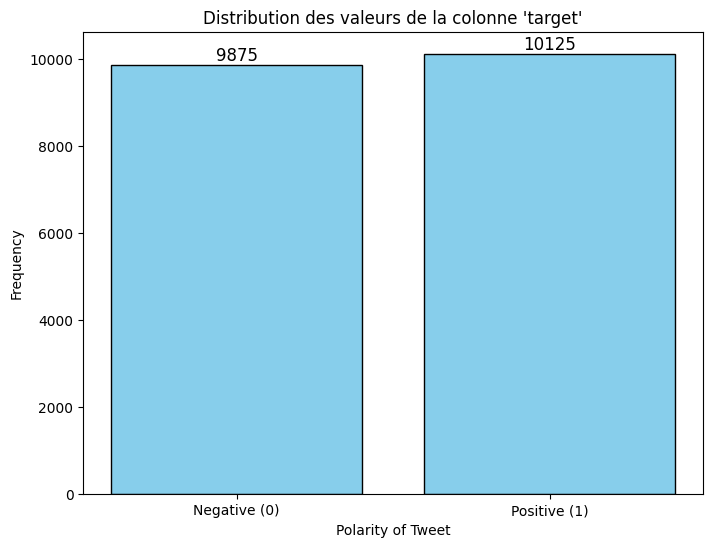

In [6]:
# Créer un histogramme des valeurs de la colonne 'target' avec des étiquettes spécifiques et le nombre total de valeurs

# Compter les occurrences de chaque valeur unique dans 'target' avec les valeurs 0, 1
target_counts = df_sample['target'].value_counts().reindex([0, 1], fill_value=0)

# Configurer le graphique
plt.figure(figsize=(8, 6))
bars = plt.bar(['Negative (0)', 'Positive (1)'], target_counts, color='skyblue', edgecolor='black')

# Ajouter les annotations (le nombre total au-dessus de chaque colonne)
for bar, count in zip(bars, target_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count}', ha='center', va='bottom', fontsize=12)

# Personnaliser l'apparence du graphique
plt.title("Distribution des valeurs de la colonne 'target'")
plt.xlabel("Polarity of Tweet")
plt.ylabel("Frequency")
plt.show()

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
# Classe de prétraitement et vectorisation des tweets avec différentes méthodes
types_of_embeddings = ['w2v', 'fasttext', 'bert', 'use']

In [9]:
# Classe de prétraitement et vectorisation des tweets avec différentes méthodes
class TweetVectorizer:
    def __init__(self, vectorizer_type='w2v', method='lemmatize'):
        self.vectorizer_type = vectorizer_type
        self.method = method
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        
        # Initialiser le vectorizer en fonction du type
        if vectorizer_type == 'w2v':
            self.model = None  # Placeholder pour Word2Vec qui sera entraîné explicitement
        elif vectorizer_type == 'fasttext':
            self.fasttext_model = FastText(vector_size=100, window=5, min_count=1)
        elif vectorizer_type == 'bert':
            self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
            self.model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
        elif vectorizer_type == 'use':
            self.use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
        else:
            raise ValueError("vectorizer_type doit être 'w2v', 'fasttext', 'bert', ou 'use'")
    
    def clean_tweet(self, tweet):
        tweet = tweet.lower()
        tweet = re.sub(r'www\S+|http\S+', '', tweet)
        tweet = re.sub(r'@\w+', '', tweet)
        tweet = re.sub(r'#\w+', '', tweet)
        tweet = re.sub(r'[^A-Za-z ]+', ' ', tweet)
        tweet = re.sub(r'\s+', ' ', tweet)
        return tweet.strip()
        
    def preprocess(self, tweet):
        cleaned_tweet = self.clean_tweet(tweet)
        tokens = cleaned_tweet.split()
        
        # Appliquer le stemming ou la lemmatisation
        if self.method == 'stem':
            tokens = [self.stemmer.stem(token) for token in tokens]
        elif self.method == 'lemmatize':
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(tokens)
    
    # Méthode `fit_transform` mise à jour dans TweetVectorizer pour vérifier et ajuster la forme
    def fit_transform(self, documents):
        documents_preprocessed = [self.preprocess(doc) for doc in documents]
        
        if self.vectorizer_type == 'w2v':
            tokenized_docs = [doc.split() for doc in documents_preprocessed]
            self.model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=1, workers=4)
            X = np.array([np.mean([self.model.wv[word] for word in words if word in self.model.wv] or [np.zeros(100)], axis=0) for words in tokenized_docs])
        elif self.vectorizer_type == 'fasttext':
            tokenized_docs = [doc.split() for doc in documents_preprocessed]
            self.fasttext_model.build_vocab(tokenized_docs)
            self.fasttext_model.train(tokenized_docs, total_examples=len(tokenized_docs), epochs=10)
            X = np.array([np.mean([self.fasttext_model.wv[word] for word in words if word in self.fasttext_model.wv] or [np.zeros(100)], axis=0) for words in tokenized_docs])
        elif self.vectorizer_type == 'bert':
            X = self._bert_vectorize(documents_preprocessed)
        elif self.vectorizer_type == 'use':
            X = self.use_model(documents_preprocessed)
            X = np.array(X)
        
        # Assurer que X est bien en 2D
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        elif X.ndim == 2 and X.shape[1] == 1:
            # S'assurer que la deuxième dimension correspond bien à l'embedding dimension
            X = X.reshape(-1, X.shape[1])
        
        return X

    def transform(self, documents):
        documents_preprocessed = [self.preprocess(doc) for doc in documents]
        
        if self.vectorizer_type == 'w2v':
            tokenized_docs = [doc.split() for doc in documents_preprocessed]
            X = np.array([np.mean([self.model.wv[word] for word in words if word in self.model.wv] or [np.zeros(100)], axis=0) for words in tokenized_docs])
        elif self.vectorizer_type == 'fasttext':
            tokenized_docs = [doc.split() for doc in documents_preprocessed]
            X = np.array([np.mean([self.fasttext_model.wv[word] for word in words if word in self.fasttext_model.wv] or [np.zeros(100)], axis=0) for words in tokenized_docs])
        elif self.vectorizer_type == 'bert':
            X = self._bert_vectorize(documents_preprocessed)
        elif self.vectorizer_type == 'use':
            X = self.use_model(documents_preprocessed)
            X = np.array(X)
    
        # Assurer que X est bien en 2D
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        elif X.ndim == 2 and X.shape[1] == 1:
            X = X.reshape(-1, X.shape[1])
        
        return X

    def _bert_vectorize(self, documents):
        batch_size = 16  # Réduction de la taille du batch pour éviter les erreurs OOM
        batches = [documents[i:i + batch_size] for i in range(0, len(documents), batch_size)]
        
        outputs_list = []
        for batch in batches:
            tokenized_inputs = self.tokenizer(batch, return_tensors='tf', padding=True, truncation=True, max_length=32)
            outputs = self.model(tokenized_inputs).logits
            outputs_list.append(tf.reduce_mean(outputs, axis=1).numpy())
        
        return np.concatenate(outputs_list, axis=0)

In [10]:
from io import BytesIO

def log_plot_to_mlflow(figure, artifact_name):
    """
    Enregistre une figure matplotlib dans MLflow en utilisant un buffer en mémoire.

    :param figure: la figure matplotlib à sauvegarder
    :param artifact_name: le nom de l'artefact pour MLflow (inclure ".png")
    """
    # Utilisation d'un buffer en mémoire
    buffer = BytesIO()
    figure.savefig(buffer, format="png")
    buffer.seek(0)
    
    # Sauvegarder dans MLflow à partir du buffer
    with open(artifact_name, "wb") as f:
        f.write(buffer.getvalue())
    mlflow.log_artifact(artifact_name)

In [ ]:
# Classe pour la classification avec régression logistique
from sklearn.model_selection import learning_curve, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score, f1_score, precision_score, recall_score
import mlflow
import mlflow.sklearn
import numpy as np
import time
import matplotlib.pyplot as plt


all_validation_metrics = []

class TweetClassifier:
    def __init__(self, vectorizer_type='tfidf', method='lemmatize'):
        self.model = LogisticRegression(C=1.0, solver='lbfgs', penalty='l2')
        self.vectorizer_type = vectorizer_type
        self.method = method

    def train_and_evaluate(self, X_train, X_val, y_train, y_val):
        # Suivi de l'entraînement du modèle dans MLflow comme sous-exécution
        with mlflow.start_run(run_name="Classification", nested=True):
            mlflow.set_tag("Stage", "Classification")
            mlflow.set_tag("model", "Logistic Regression")
            
            # Enregistrer les hyperparamètres du modèle
            mlflow.log_param("C", self.model.get_params()['C'])
            mlflow.log_param("solver", self.model.get_params()['solver'])
            mlflow.log_param("penalty", self.model.get_params()['penalty'])
            
            # Entraîner le modèle avec Cross-Validation sur le set d'entraînement
            cv_results = cross_validate(self.model, X_train, y_train, cv=5, 
                                                            scoring=['roc_auc', 'f1', 'accuracy', 'precision', 'recall'],
                                                            return_train_score=False)

            # Stockage des résultats de cross-validation
            metrics_dict = {
                "CrossVal ROC_AUC": round(cv_results['test_roc_auc'].mean(), 3),
                "CrossVal F1": round(cv_results['test_f1'].mean(), 3),
                "CrossVal Accuracy": round(cv_results['test_accuracy'].mean(), 3),
                "CrossVal Precision": round(cv_results['test_precision'].mean(), 3),
                "CrossVal Recall": round(cv_results['test_recall'].mean(), 3),
                "CrossVal Fit Time": round(cv_results['fit_time'].mean(), 3)
            }
            
            # Enregistrer les métriques de cross-validation dans MLflow
            mlflow.log_metrics(metrics_dict)
            
            # Entraîner sur l'ensemble d'entraînement complet
            start_time = time.time()
            self.model.fit(X_train, y_train)
            end_time = time.time()
            training_time = end_time - start_time
            mlflow.log_metric("fit_time_seconds", training_time)
            
            # Évaluation sur l'ensemble de validation
            start_predict_time = time.time()
            y_val_pred = self.model.predict(X_val)
            end_predict_time = time.time()
            predict_time = end_predict_time - start_predict_time
            
            val_accuracy = accuracy_score(y_val, y_val_pred)
            mlflow.log_metric("validation_accuracy", val_accuracy)
            mlflow.log_text(classification_report(y_val, y_val_pred), "validation_classification_report.txt")
            
            # Calcul de la courbe ROC-AUC sur l'ensemble de validation
            y_val_prob = self.model.predict_proba(X_val)[:, 1]
            fpr, tpr, _ = roc_curve(y_val, y_val_prob)
            roc_auc_val = auc(fpr, tpr)
            mlflow.log_metric("validation_roc_auc", roc_auc_val)

            # Tracer et enregistrer la courbe ROC
            plt.figure()
            plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc_val:.2f})")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve - Validation Set")
            plt.legend(loc="lower right")
            log_plot_to_mlflow(plt.gcf(), "roc_curve_val.png")
            plt.close()
            
            # Tracer et enregistrer la courbe d'apprentissage
            train_sizes, train_scores, val_scores = learning_curve(
                self.model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
            )
            
            train_scores_mean = np.mean(train_scores, axis=1)
            val_scores_mean = np.mean(val_scores, axis=1)
            
            plt.figure()
            plt.plot(train_sizes, train_scores_mean, label="Training score")
            plt.plot(train_sizes, val_scores_mean, label="Validation score")
            plt.xlabel("Training Set Size")
            plt.ylabel("Accuracy")
            plt.title("Learning Curve")
            plt.legend(loc="best")
            plt.grid()
            # plt.savefig("images/modele-simple/learning_curve.png")
            # mlflow.log_artifact("images/modele-simple/learning_curve.png")
            log_plot_to_mlflow(plt.gcf(), "learning_curve.png")
            plt.close()
            
            # Calcul des métriques de validation uniquement
            validation_metrics = {    
                "Validation Accuracy": round(accuracy_score(y_val, y_val_pred), 3),
                "Validation ROC_AUC": round(roc_auc_score(y_val, y_val_prob), 3),
                "Validation F1": round(f1_score(y_val, y_val_pred), 3),
                "Validation Precision": round(precision_score(y_val, y_val_pred), 3),
                "Validation Recall": round(recall_score(y_val, y_val_pred), 3),
                "Validation Predict Time": round(predict_time, 3)
            }
            
            mlflow.log_table(validation_metrics, "validation_metrics_table.json")
            # Sauvegarde du modèle pour reproductibilité
            mlflow.sklearn.log_model(self.model, "RegLog_"+self.vectorizer_type+"_"+self.method)
            # Enregistrer le modèle final}
            #mlflow.sklearn.log_model(self.model, "logistic_regression_model")
            run_id = mlflow.active_run().info.run_id
            result = mlflow.register_model(
                model_uri=f"runs:/{run_id}/model",
                name=f"RegLog_{self.vectorizer_type}_{self.method}"
            )

             # Exemple d'ajout d'un dictionnaire pour chaque configuration
            # Ajouter les métriques de validation à la liste
            all_validation_metrics.append({
                "vectorizer_type": self.vectorizer_type,
                "method": self.method,
                **validation_metrics
            })
            
            print(f"Validation Accuracy : {val_accuracy}")
            print(classification_report(y_val, y_val_pred))
    
    def final_evaluation(self, X_test, y_test):
        # Évaluation finale sur le set de test
        with mlflow.start_run(run_name="Final Test Evaluation", nested=True):
            mlflow.set_tag("Stage", "Final Test Evaluation")
            y_test_pred = self.model.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_test_pred)
            mlflow.log_metric("test_accuracy", test_accuracy)
            mlflow.log_text(classification_report(y_test, y_test_pred), "test_classification_report.txt")
            
            # Calcul de la courbe ROC-AUC sur l'ensemble de test
            y_test_prob = self.model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_test_prob)
            roc_auc_test = auc(fpr, tpr)
            mlflow.log_metric("test_roc_auc", roc_auc_test)
            
            metrics_dict = {
                "test_accuracy": test_accuracy,
                "test_roc_auc": roc_auc_test
            }
            
            mlflow.log_table(metrics_dict, "test_metrics_table.json")
            mlflow.set_tag("test_accuracy", test_accuracy)
            mlflow.set_tag("final_evaluation_metric", "test_roc_auc")

            # Tracer et enregistrer la courbe ROC pour le set de test
            plt.figure()
            plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc_test:.2f})")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve - Test Set")
            plt.legend(loc="lower right")
            log_plot_to_mlflow(plt.gcf(), "roc_curve_test.png")
            plt.close()
            
            # Enregistrer le modèle final
            mlflow.sklearn.log_model(self.model, "logistic_regression_model")
            
            print(f"Test Accuracy : {test_accuracy}")
            print(classification_report(y_test, y_test_pred))


In [12]:
# Définition des combinaisons à tester
configurations = [
    {'vectorizer_type': 'w2v', 'method': 'lemmatize'},
    {'vectorizer_type': 'w2v', 'method': 'stem'},
    {'vectorizer_type': 'fasttext', 'method': 'lemmatize'},
    {'vectorizer_type': 'fasttext', 'method': 'stem'},
    {'vectorizer_type': 'bert', 'method': 'lemmatize'},
    {'vectorizer_type': 'bert', 'method': 'stem'},
    {'vectorizer_type': 'use', 'method': 'lemmatize'},
    {'vectorizer_type': 'use', 'method': 'stem'}
]

Testing configuration: {'vectorizer_type': 'w2v', 'method': 'lemmatize'}


2024/11/17 15:19:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'RegLog_w2v_lemmatize'.
2024/11/17 15:19:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RegLog_w2v_lemmatize, version 1
Created version '1' of model 'RegLog_w2v_lemmatize'.
2024/11/17 15:19:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run Classification at: http://mlflow-server:5000/#/experiments/4/runs/96bad0d6724344c09a1907e886f9a1cb.
2024/11/17 15:19:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Validation Accuracy : 0.625
              precision    recall  f1-score   support

           0       0.63      0.60      0.61      2001
           1       0.62      0.65      0.64      1999

    accuracy                           0.62      4000
   macro avg       0.63      0.63      0.62      4000
weighted avg       0.63      0.62      0.62      4000



2024/11/17 15:19:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/17 15:19:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/4/runs/c446c586e2ad4828b2882dba77f933db.
2024/11/17 15:19:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.
2024/11/17 15:19:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run w2v + lemmatize at: http://mlflow-server:5000/#/experiments/4/runs/f963ab07f9744a3a88dcfe1b97091563.
2024/11/17 15:19:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Test Accuracy : 0.637
              precision    recall  f1-score   support

           0       0.64      0.59      0.62      1975
           1       0.63      0.68      0.65      2025

    accuracy                           0.64      4000
   macro avg       0.64      0.64      0.64      4000
weighted avg       0.64      0.64      0.64      4000

Testing configuration: {'vectorizer_type': 'w2v', 'method': 'stem'}


2024/11/17 15:19:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'RegLog_w2v_stem'.
2024/11/17 15:19:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RegLog_w2v_stem, version 1
Created version '1' of model 'RegLog_w2v_stem'.
2024/11/17 15:19:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run Classification at: http://mlflow-server:5000/#/experiments/4/runs/ad37c97fc6eb4973a6cf8956b9d90062.
2024/11/17 15:19:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Validation Accuracy : 0.632
              precision    recall  f1-score   support

           0       0.64      0.60      0.62      2001
           1       0.62      0.66      0.64      1999

    accuracy                           0.63      4000
   macro avg       0.63      0.63      0.63      4000
weighted avg       0.63      0.63      0.63      4000



2024/11/17 15:19:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/17 15:19:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/4/runs/8d96495017a24e04b297c4853eddfb68.
2024/11/17 15:19:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.
2024/11/17 15:19:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run w2v + stem at: http://mlflow-server:5000/#/experiments/4/runs/824401b74fa04604870d62b439135704.
2024/11/17 15:19:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Test Accuracy : 0.63475
              precision    recall  f1-score   support

           0       0.64      0.59      0.62      1975
           1       0.63      0.68      0.65      2025

    accuracy                           0.63      4000
   macro avg       0.64      0.63      0.63      4000
weighted avg       0.64      0.63      0.63      4000

Testing configuration: {'vectorizer_type': 'fasttext', 'method': 'lemmatize'}


/opt/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Validation Accuracy : 0.6465
              precision    recall  f1-score   support

           0       0.65      0.64      0.64      2001
           1       0.64      0.66      0.65      1999

    accuracy                           0.65      4000
   macro avg       0.65      0.65      0.65      4000
weighted avg       0.65      0.65      0.65      4000



2024/11/17 15:19:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/17 15:19:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/4/runs/7818bfefeae244aca033de2fdfa1ecc4.
2024/11/17 15:19:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.
2024/11/17 15:19:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run fasttext + lemmatize at: http://mlflow-server:5000/#/experiments/4/runs/0ff9235e8b7f465cbfb84479fb64c548.
2024/11/17 15:19:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Test Accuracy : 0.653
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      1975
           1       0.65      0.68      0.66      2025

    accuracy                           0.65      4000
   macro avg       0.65      0.65      0.65      4000
weighted avg       0.65      0.65      0.65      4000

Testing configuration: {'vectorizer_type': 'fasttext', 'method': 'stem'}


/opt/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Validation Accuracy : 0.64825
              precision    recall  f1-score   support

           0       0.65      0.64      0.65      2001
           1       0.65      0.65      0.65      1999

    accuracy                           0.65      4000
   macro avg       0.65      0.65      0.65      4000
weighted avg       0.65      0.65      0.65      4000



2024/11/17 15:19:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/17 15:19:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/4/runs/737963bf74a54c31ab4cfadd48129914.
2024/11/17 15:19:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.
2024/11/17 15:19:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run fasttext + stem at: http://mlflow-server:5000/#/experiments/4/runs/fe78416d605f401dab19715dd783a1f3.
2024/11/17 15:19:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Test Accuracy : 0.66025
              precision    recall  f1-score   support

           0       0.66      0.65      0.65      1975
           1       0.66      0.68      0.67      2025

    accuracy                           0.66      4000
   macro avg       0.66      0.66      0.66      4000
weighted avg       0.66      0.66      0.66      4000

Testing configuration: {'vectorizer_type': 'bert', 'method': 'lemmatize'}


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

2024-11-17 15:19:35.295876: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2024-11-17 15:19:35.399322: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2024-11-17 15:19:35.487093: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2024-11-17 15:19:35.502768: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2024-11-17 15:19:36.358469: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and ar

Validation Accuracy : 0.52425
              precision    recall  f1-score   support

           0       0.54      0.34      0.41      2001
           1       0.52      0.71      0.60      1999

    accuracy                           0.52      4000
   macro avg       0.53      0.52      0.51      4000
weighted avg       0.53      0.52      0.51      4000



2024/11/17 15:29:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/17 15:29:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/4/runs/b629a36551cf4b57a09a5c65c6900440.
2024/11/17 15:29:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.
2024/11/17 15:29:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run bert + lemmatize at: http://mlflow-server:5000/#/experiments/4/runs/530b721c8ab346c3a6e7f890caf65bb9.
2024/11/17 15:29:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Test Accuracy : 0.53175
              precision    recall  f1-score   support

           0       0.54      0.33      0.41      1975
           1       0.53      0.72      0.61      2025

    accuracy                           0.53      4000
   macro avg       0.53      0.53      0.51      4000
weighted avg       0.53      0.53      0.51      4000

Testing configuration: {'vectorizer_type': 'bert', 'method': 'stem'}


2024-11-17 15:29:13.122318: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadl

Validation Accuracy : 0.537
              precision    recall  f1-score   support

           0       0.55      0.44      0.49      2001
           1       0.53      0.63      0.58      1999

    accuracy                           0.54      4000
   macro avg       0.54      0.54      0.53      4000
weighted avg       0.54      0.54      0.53      4000



2024/11/17 15:38:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/17 15:38:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/4/runs/9384dd6204af4817af7e4b8ae08dd696.
2024/11/17 15:38:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.
2024/11/17 15:38:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run bert + stem at: http://mlflow-server:5000/#/experiments/4/runs/fa0a1463585942c38ed3cddd99801e7e.
2024/11/17 15:38:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Test Accuracy : 0.53475
              precision    recall  f1-score   support

           0       0.54      0.42      0.47      1975
           1       0.53      0.65      0.58      2025

    accuracy                           0.53      4000
   macro avg       0.54      0.53      0.53      4000
weighted avg       0.54      0.53      0.53      4000

Testing configuration: {'vectorizer_type': 'use', 'method': 'lemmatize'}


2024/11/17 15:39:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'RegLog_use_lemmatize'.
2024/11/17 15:39:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RegLog_use_lemmatize, version 1
Created version '1' of model 'RegLog_use_lemmatize'.
2024/11/17 15:39:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run Classification at: http://mlflow-server:5000/#/experiments/4/runs/f41db6b1e0d043fe93ff373e74c56802.
2024/11/17 15:39:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Validation Accuracy : 0.76075
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      2001
           1       0.76      0.76      0.76      1999

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



2024/11/17 15:39:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/17 15:39:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/4/runs/adfd0d96d1704636a5f9d7bef27dd369.
2024/11/17 15:39:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.
2024/11/17 15:39:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run use + lemmatize at: http://mlflow-server:5000/#/experiments/4/runs/87375862e7824762bb1ae9fcf147d62d.
2024/11/17 15:39:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Test Accuracy : 0.7675
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1975
           1       0.77      0.78      0.77      2025

    accuracy                           0.77      4000
   macro avg       0.77      0.77      0.77      4000
weighted avg       0.77      0.77      0.77      4000

Testing configuration: {'vectorizer_type': 'use', 'method': 'stem'}


2024/11/17 15:39:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'RegLog_use_stem'.
2024/11/17 15:39:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RegLog_use_stem, version 1
Created version '1' of model 'RegLog_use_stem'.
2024/11/17 15:39:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run Classification at: http://mlflow-server:5000/#/experiments/4/runs/b794ad12f8a349f5affe00c5b370f685.
2024/11/17 15:39:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Validation Accuracy : 0.74125
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      2001
           1       0.74      0.74      0.74      1999

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000



2024/11/17 15:39:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/17 15:39:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/4/runs/0d6de89750054992b1298895cec18fe0.
2024/11/17 15:39:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.
2024/11/17 15:39:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run use + stem at: http://mlflow-server:5000/#/experiments/4/runs/6af6ec0180bf4c4b9edfe7bec09fb0c1.
2024/11/17 15:39:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Test Accuracy : 0.739
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1975
           1       0.74      0.76      0.75      2025

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000



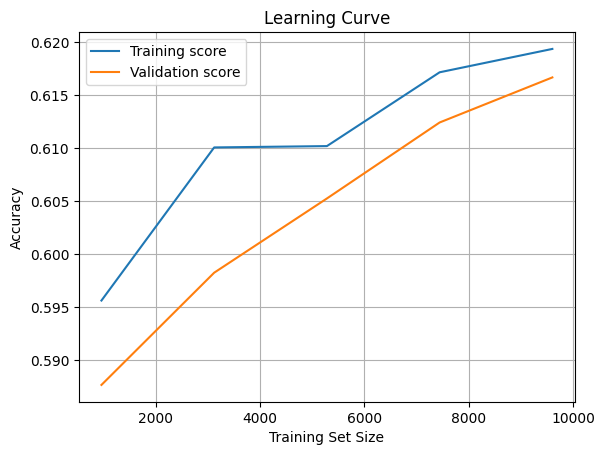

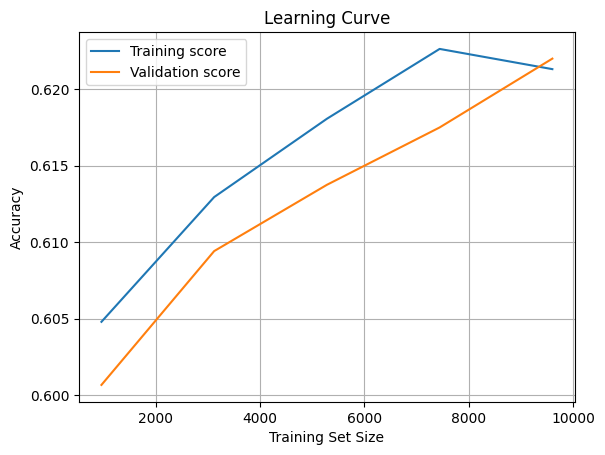

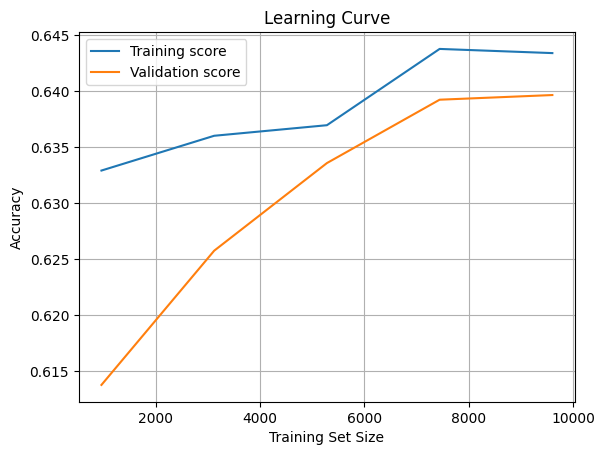

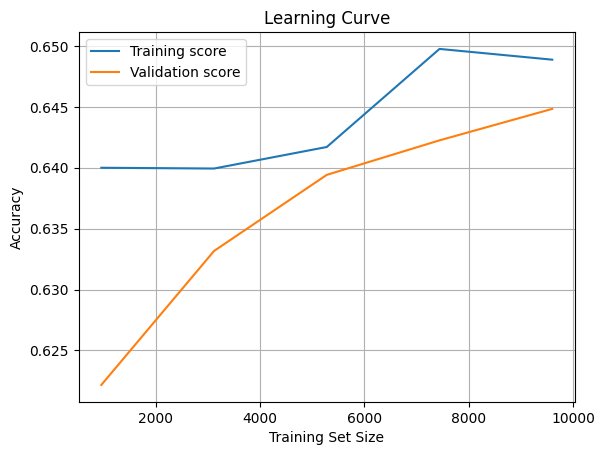

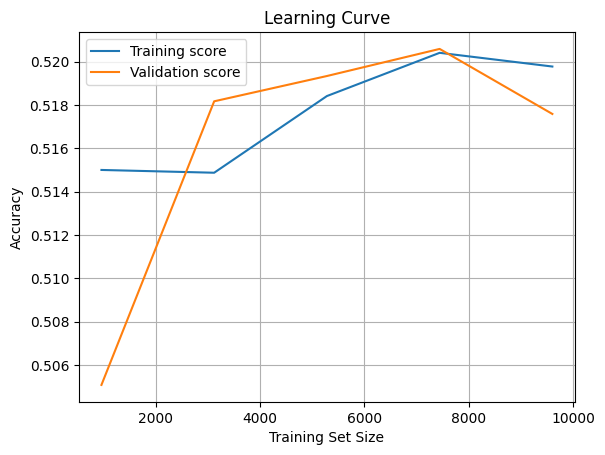

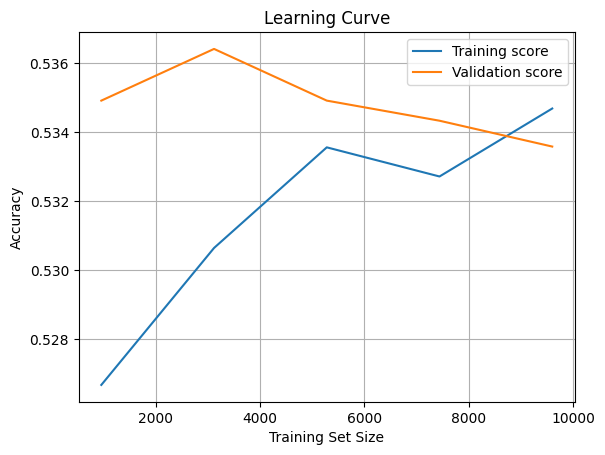

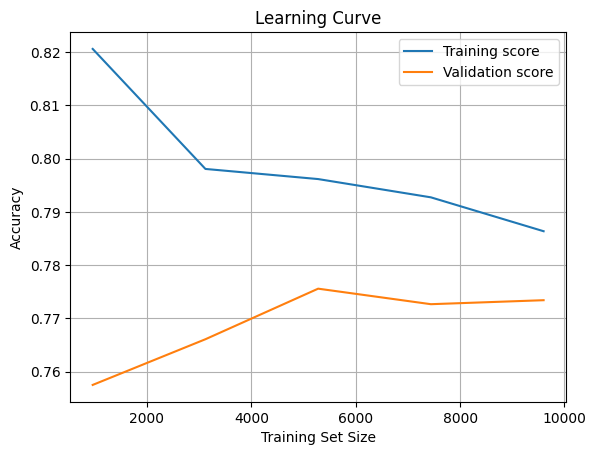

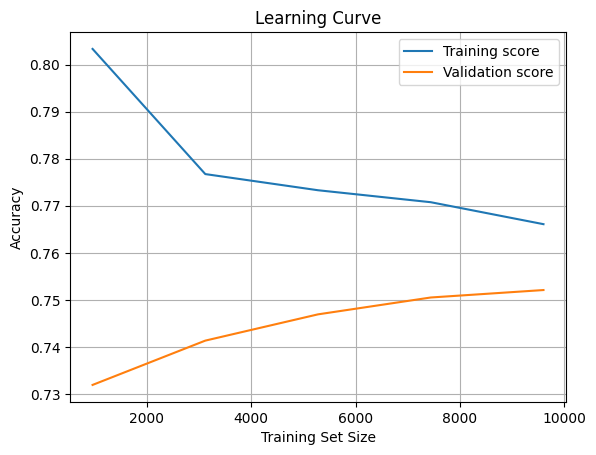

In [17]:
experiment = mlflow.set_experiment("advanced-models")
# Séparer les données en Train, Validation et Test une seule fois
# Utiliser les tweets originaux pour diviser les ensembles de manière cohérente
y = df_sample['target']
tweets = df_sample['text']
y_train_val, y_test = train_test_split(y, test_size=0.2, random_state=42)
tweets_train_val, tweets_test = train_test_split(tweets, test_size=0.2, random_state=42)

# Rediviser l'ensemble Train + Validation en Train et Validation
y_train, y_val = train_test_split(y_train_val, test_size=0.25, random_state=42)
tweets_train, tweets_val = train_test_split(tweets_train_val, test_size=0.25, random_state=42)

# Boucle pour tester chaque configuration
for config in configurations:
    # Démarrer une nouvelle exécution parent pour chaque configuration
    with mlflow.start_run(run_name=f"{config['vectorizer_type']} + {config['method']}", nested=False):
        print(f"Testing configuration: {config}")
        
        # Enregistrer les paramètres de configuration comme tags
        mlflow.set_tag("vectorizer_type", config['vectorizer_type'])
        mlflow.set_tag("preprocessing_method", config['method'])
        
        # Initialiser et appliquer la vectorisation avec TweetVectorizer
        tweet_vectorizer = TweetVectorizer(vectorizer_type=config['vectorizer_type'], method=config['method'])
        
        # Vectorisation des ensembles Train, Validation et Test
        X_train = tweet_vectorizer.fit_transform(tweets_train)
        X_val = tweet_vectorizer.transform(tweets_val)
        X_test = tweet_vectorizer.transform(tweets_test)
        
        # Initialiser le classificateur
        classifier = TweetClassifier(vectorizer_type=config['vectorizer_type'], method=config['method'])
        
        # Entraîner et évaluer le modèle avec Train et Validation
        classifier.train_and_evaluate(X_train, X_val, y_train, y_val)

        # Évaluation finale sur le set de Test
        classifier.final_evaluation(X_test, y_test)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional  # Ajout de Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec, FastText

In [ ]:
class LSTMTweetClassifier:
    def __init__(self, embedding_type='w2v', embedding_dim=100, lstm_units=128, max_length=100):
        self.embedding_type = embedding_type
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.max_length = max_length
        self.tokenizer = Tokenizer()
        self.model = None
        self.stop_words = set(stopwords.words('english'))

    def clean_tweet(self, tweet):
        """Nettoie le texte du tweet en supprimant les liens, mentions, hashtags et caractères spéciaux."""
        tweet = tweet.lower()
        tweet = re.sub(r'www\S+|http\S+', '', tweet)  # Supprime les liens
        tweet = re.sub(r'@\w+', '', tweet)            # Supprime les mentions
        tweet = re.sub(r'#\w+', '', tweet)            # Supprime les hashtags
        tweet = re.sub(r'[^A-Za-z ]+', ' ', tweet)    # Supprime les caractères spéciaux
        tweet = re.sub(r'\s+', ' ', tweet)            # Remplace les multiples espaces par un seul espace
        return tweet.strip()

    def preprocess_and_tokenize(self, documents):
        # Nettoyage et suppression des stopwords
        cleaned_docs = []
        for doc in documents:
            cleaned_doc = self.clean_tweet(doc)
            words = cleaned_doc.split()
            filtered_words = [word for word in words if word not in self.stop_words]
            cleaned_docs.append(' '.join(filtered_words))
        
        # Convertir les documents nettoyés en tokens
        self.tokenizer.fit_on_texts(cleaned_docs)
        sequences = self.tokenizer.texts_to_sequences(cleaned_docs)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length, padding='post')
        return padded_sequences

    def build_embedding_matrix(self, documents):
        word_index = self.tokenizer.word_index
        vocab_size = len(word_index) + 1
        embedding_matrix = np.zeros((vocab_size, self.embedding_dim))
        
        # Préparation des phrases pour l'entraînement d'embeddings
        sentences = [self.clean_tweet(doc).split() for doc in documents]
        
        if self.embedding_type == 'w2v':
            model = Word2Vec(sentences=sentences, vector_size=self.embedding_dim, window=5, min_count=1, workers=4)
        elif self.embedding_type == 'fasttext':
            model = FastText(sentences=sentences, vector_size=self.embedding_dim, window=5, min_count=1, workers=4)
        else:
            raise ValueError("embedding_type must be 'w2v' or 'fasttext'")
        
        for word, i in word_index.items():
            if word in model.wv:
                embedding_matrix[i] = model.wv[word]
        
        return embedding_matrix

    def build_model(self, vocab_size, embedding_matrix):
        """Construit le modèle LSTM avec les paramètres spécifiés."""
        self.model = Sequential()
        self.model.add(Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, 
                                 weights=[embedding_matrix], input_length=self.max_length, trainable=False))
        self.model.add(Bidirectional(LSTM(self.lstm_units, return_sequences=False)))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def track_metrics(self, y_true, y_pred, prefix=""):
        """Enregistre les métriques de classification dans MLflow."""
        accuracy = np.mean((y_pred > 0.5).flatten() == y_true)
        auc = roc_auc_score(y_true, y_pred)
        mlflow.log_metric(f"{prefix}_accuracy", accuracy)
        mlflow.log_metric(f"{prefix}_auc", auc)
        return accuracy, auc

    def train_and_evaluate(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        """Entraîne le modèle et enregistre les métriques et modèles dans MLflow."""
        if self.model is None:
            raise RuntimeError("Model has not been built. Call build_model() before training.")
        
        with mlflow.start_run(run_name=f"{self.embedding_type}_{self.embedding_dim}_{self.lstm_units}_{epochs}_{batch_size}"):
            # Log des hyperparamètres spécifiques à cette configuration
            mlflow.log_param("embedding_type", self.embedding_type)
            mlflow.log_param("embedding_dim", self.embedding_dim)
            mlflow.log_param("lstm_units", self.lstm_units)
            mlflow.log_param("epochs", epochs)
            mlflow.log_param("batch_size", batch_size)

            start_time = time.time()
            history = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs, batch_size=batch_size
            )
            train_duration = time.time() - start_time
            mlflow.log_metric("train_duration", train_duration)

            # Log des métriques d'entraînement et de validation
            for epoch in range(epochs):
                mlflow.log_metric("train_loss", history.history['loss'][epoch], step=epoch)
                mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
                mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], step=epoch)
                mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)
        
            # Évaluation sur l'ensemble de validation
            y_val_pred = self.model.predict(X_val).flatten()
            self.track_metrics(y_val, y_val_pred, prefix="val")

            # Log du modèle
            mlflow.keras.log_model(self.model, "model")

    def fit(self, documents, labels, val_split=0.2, epochs=10, batch_size=32):
        padded_sequences = self.preprocess_and_tokenize(documents)
        vocab_size = len(self.tokenizer.word_index) + 1
        embedding_matrix = self.build_embedding_matrix(documents)

        self.build_model(vocab_size, embedding_matrix)

        split_index = int(len(padded_sequences) * (1 - val_split))
        X_train, X_val = padded_sequences[:split_index], padded_sequences[split_index:]
        y_train, y_val = labels[:split_index], labels[split_index:]
        
        self.train_and_evaluate(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)

    def predict(self, documents):
        padded_sequences = self.preprocess_and_tokenize(documents)
        predictions = self.model.predict(padded_sequences)
        return (predictions > 0.5).astype(int).flatten()

In [ ]:
# Définition des combinaisons à tester
configurations = [
    {
        "embedding_type": "w2v",
        "embedding_dim": 50,
        "lstm_units": 64,
        "epochs": 5,
        "batch_size": 32
    },
    {
        "embedding_type": "w2v",
        "embedding_dim": 100,
        "lstm_units": 128,
        "epochs": 10,
        "batch_size": 32
    },
    {
        "embedding_type": "fasttext",
        "embedding_dim": 50,
        "lstm_units": 64,
        "epochs": 5,
        "batch_size": 32
    },
    {
        "embedding_type": "fasttext",
        "embedding_dim": 100,
        "lstm_units": 128,
        "epochs": 10,
        "batch_size": 32
    },
    # Vous pouvez ajouter d'autres configurations ici
]


In [ ]:
experiment = mlflow.set_experiment("LSTM")
documents = df_sample['text']
labels = df_sample['target']

# Boucle sur chaque configuration pour tester
for config in configurations:
    print(f"\n Testing configuration: {config} \n")
    model = LSTMTweetClassifier(
        embedding_type=config["embedding_type"],
        embedding_dim=config["embedding_dim"],
        max_length=100  # Vous pouvez ajuster cette valeur si nécessaire
    )
    # Entraînement du modèle avec la configuration actuelle
    model.fit(
        documents, 
        labels, 
        epochs=config["epochs"], 
        batch_size=config["batch_size"]
    )
    
    # Ici, vous pouvez ajouter des étapes pour enregistrer ou comparer les résultats, par exemple :
    # - Enregistrer les métriques dans un dictionnaire ou un fichier pour une analyse ultérieure
    # - Comparer les résultats dans MLFlow
    print(f"Finished testing configuration: {config}\n")

In [ ]:
from tensorflow.keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def __init__(self, monitor='val_loss', patience=2, restore_best_weights=True):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        self.best = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current < self.best:
            self.best = current
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                if self.restore_best_weights:
                    self.model.set_weights(self.best_weights)

In [ ]:
# from transformers import BertTokenizer, TFBertForSequenceClassification
# from tensorflow.keras.losses import SparseCategoricalCrossentropy
# from sklearn.model_selection import train_test_split
# import tensorflow as tf
# import numpy as np

# class SimpleBERTTrainer:
#     def __init__(self, model_name='bert-base-uncased', max_length=128, learning_rate=2e-5):
#         self.model_name = model_name
#         self.max_length = max_length
#         self.learning_rate = learning_rate
#         self.tokenizer = BertTokenizer.from_pretrained(model_name)
#         self.model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

#     def train(self, documents, labels, test_size=0.95, epochs=3, batch_size=16):
#         # Assurez-vous que labels est de type int32
#         labels = np.array(labels, dtype=np.int32)
        
#         # Tokenisation et encodage des textes directement dans train
#         encoding = self.tokenizer(
#             documents.tolist(),
#             add_special_tokens=True,
#             max_length=self.max_length,
#             padding='max_length',
#             truncation=True,
#             return_tensors='np'
#         )
        
#         # Récupération des ID et masques d'attention depuis le tokenizer
#         input_ids = encoding['input_ids']
#         attention_masks = encoding['attention_mask']
        
#         # Division des données en ensemble d'entraînement et de validation
#         X_train_ids, X_val_ids, X_train_masks, X_val_masks, y_train, y_val = train_test_split(
#             input_ids, attention_masks, labels, test_size=test_size, random_state=42
#         )
        
#         # Compilation du modèle avec une fonction de perte explicite
#         loss_fn = SparseCategoricalCrossentropy(from_logits=True)
#         self.model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
        
#         # Entraînement du modèle
#         history = self.model.fit(
#             [X_train_ids, X_train_masks], y_train,
#             validation_data=([X_val_ids, X_val_masks], y_val),
#             epochs=epochs,
#             batch_size=batch_size
#         )
        
#         # Affichage des résultats d'entraînement et de validation
#         train_accuracy = history.history['accuracy'][-1]
#         val_accuracy = history.history['val_accuracy'][-1]
#         print(f"Train Accuracy: {train_accuracy:.4f}")
#         print(f"Validation Accuracy: {val_accuracy:.4f}")

In [ ]:
# Utilisation de la classe SimpleBERTTrainer pour entraîner et évaluer BERT
# documents = [...]  # Remplacez par la liste de tweets
# labels = [...]     # Remplacez par la liste des labels (0 ou 1)
documents = df_sample['text']
labels = df_sample['target']

# Initialisation et entraînement du modèle
bert_trainer = SimpleBERTTrainer()
bert_trainer.train(documents, labels, epochs=3, batch_size=16)


In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

class SimpleBERTTrainer:
    def __init__(self, model_name='cardiffnlp/twitter-roberta-base-sentiment', max_length=128, learning_rate=1e-5):
    #def __init__(self, model_name='vinai/bertweet-base', max_length=128, learning_rate=1e-5):
        self.model_name = model_name
        self.max_length = max_length
        self.learning_rate = learning_rate
        # Chargement du tokenizer et du modèle pré-entraîné pour les tweets
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

    def train(self, documents, labels, test_size=0.98, epochs=3, batch_size=16):
        # Assurez-vous que labels est de type int32
        labels = np.array(labels, dtype=np.int32)
        
        # Tokenisation et encodage des textes directement dans train
        encoding = self.tokenizer(
            documents.tolist(),
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='np'
        )
        
        # Récupération des ID et masques d'attention depuis le tokenizer
        input_ids = encoding['input_ids']
        attention_masks = encoding['attention_mask']
        
        # Division des données en ensemble d'entraînement et de validation
        X_train_ids, X_val_ids, X_train_masks, X_val_masks, y_train, y_val = train_test_split(
            input_ids, attention_masks, labels, test_size=test_size, random_state=42
        )
        
        # Compilation du modèle avec une fonction de perte explicite
        loss_fn = SparseCategoricalCrossentropy(from_logits=True)
        self.model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
        
        # Entraînement du modèle
        history = self.model.fit(
            [X_train_ids, X_train_masks], y_train,
            validation_data=([X_val_ids, X_val_masks], y_val),
            epochs=epochs,
            batch_size=batch_size
        )
        
        # Affichage des résultats d'entraînement et de validation
        train_accuracy = history.history['accuracy'][-1]
        val_accuracy = history.history['val_accuracy'][-1]
        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")

    def predict(self, document):
        # Préparation du tweet pour la prédiction
        encoding = self.tokenizer(
            document,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='tf'
        )
        
        # Prédiction
        outputs = self.model(encoding)
        logits = outputs.logits
        predicted_class = tf.argmax(logits, axis=-1).numpy()[0]
        
        # Mapping pour binaire (1 = positif, 0 = négatif)
        if predicted_class == 2:  # 'neutre' sera mappé à 'positif' pour une classification binaire
            predicted_class = 1

        return predicted_class

In [ ]:
documents = df_sample['text']
labels = df_sample['target']

# Initialisation et entraînement du modèle
bert_trainer = SimpleBERTTrainer()
bert_trainer.train(documents, labels, epochs=3, batch_size=8)

In [ ]:
# Exemple de tweets à tester
tweets_to_test = [
    "Absolutely loved the flight experience! The crew was amazing and super friendly. 😊✈️",
    "Just reached my destination, and the airline service was top-notch! Highly recommend. 👍 #BestExperience",
    "Thank you @Airline for a smooth journey! Loved every moment. ✨ #TravelGoals",
    "The flight was delayed for hours with no proper explanation. Very disappointed. 😠 #NeverAgain",
    "Horrible experience! Lost my luggage, and customer service was no help at all. 😡",
    "Worst airline ever! Dirty seats and rude staff. Not flying with them again. 👎 #BadService",
    "Flight was okay, nothing special but got me where I needed to be.",
    "Had an average experience, some good and some bad moments.",
    "The service was decent, but I've had better flights with other airlines.",
    "The journey was long but managed to relax and enjoy the view. #Peaceful",
    "Pretty decent trip overall! Minor hiccups, but the crew handled them well.",
    "Could have been better, but I’m grateful to have reached safely."
]

# Classe de modèle initialisée
bert_trainer = SimpleBERTTrainer()

# Fonction pour tester plusieurs tweets
def test_tweets(tweets, model):
    for tweet in tweets:
        prediction = model.predict(tweet)
        sentiment = "Positif" if prediction == 1 else "Négatif"
        print(f"Tweet: {tweet}")
        print(f"Sentiment prédit: {sentiment}\n")

# Exécution des tests
test_tweets(tweets_to_test, bert_trainer)


In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np

# Chargement du tokenizer et du modèle pré-entraîné pour les tweets
#model_name = "cardiffnlp/twitter-roberta-base-sentiment"
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

# Liste de tweets à tester
tweets_to_test = [
    "Absolutely loved the flight experience! The crew was amazing and super friendly. 😊✈️",
    "Just reached my destination, and the airline service was top-notch! Highly recommend. 👍 #BestExperience",
    "Thank you @Airline for a smooth journey! Loved every moment. ✨ #TravelGoals",
    "The flight was delayed for hours with no proper explanation. Very disappointed. 😠 #NeverAgain",
    "Horrible experience! Lost my luggage, and customer service was no help at all. 😡",
    "Worst airline ever! Dirty seats and rude staff. Not flying with them again. 👎 #BadService",
    "Flight was okay, nothing special but got me where I needed to be.",
    "Had an average experience, some good and some bad moments.",
    "The service was decent, but I've had better flights with other airlines.",
    "The journey was long but managed to relax and enjoy the view. #Peaceful",
    "Pretty decent trip overall! Minor hiccups, but the crew handled them well.",
    "Could have been better, but I’m grateful to have reached safely."
]

# Fonction pour tester plusieurs tweets
def test_tweets(tweets, tokenizer, model):
    for tweet in tweets:
        # Tokenisation et encodage du tweet
        inputs = tokenizer(tweet, return_tensors="tf", padding=True, truncation=True, max_length=128)
        outputs = model(inputs)
        logits = outputs.logits
        predicted_class = tf.argmax(logits, axis=-1).numpy()[0]
        
        # Mapping de la classe pour une interprétation binaire
        sentiment = "Positif" if predicted_class in [1, 2] else "Négatif"  # 1 (neutre) et 2 (positif) sont considérés positifs
        
        # Affichage du tweet et du sentiment prédit
        print(f"Tweet: {tweet}")
        print(f"Sentiment prédit: {sentiment}\n")

# Exécution des tests
test_tweets(tweets_to_test, tokenizer, model)


In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm 

# Charger le tokenizer et le modèle pré-entraîné pour les tweets
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
#model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

# Jeu de données
documents = df_sample['text']
labels = df_sample['target']  # Assurez-vous que les labels sont 0 (négatif) et 1 (positif)

# Sélectionner un sous-échantillon de 10% du jeu de données
documents_sample, _, labels_sample, _ = train_test_split(documents, labels, test_size=0.90, random_state=42)

# Fonction pour effectuer les prédictions et calculer l'accuracy
def evaluate_model(documents_sample, labels, tokenizer, model):
    predictions = []
    
    for text in tqdm(documents_sample, desc="Évaluation en cours"):
        # Tokenisation et encodage du texte
        inputs = tokenizer(text, return_tensors="tf", padding=True, truncation=True, max_length=128)
        outputs = model(inputs)
        logits = outputs.logits
        predicted_class = tf.argmax(logits, axis=-1).numpy()[0]
        
        # Mapping des classes : 1 (neutre) et 2 (positif) mappés à 1 (positif), 0 reste 0 (négatif)
        if predicted_class in [1, 2]:  # Neutre et positif mappés à positif
            predicted_class = 1
        else:
            predicted_class = 0

        predictions.append(predicted_class)

    # Calcul de l'accuracy
    accuracy = np.mean(np.array(predictions) == np.array(labels))
    print(f"Accuracy du modèle sur 10% du jeu de données : {accuracy * 100:.2f}%")

# Exécution de l'évaluation sur l'échantillon de 10%
evaluate_model(documents_sample, labels_sample, tokenizer, model)


In [ ]:
import tensorflow as tf
import transformers

from transformers import TFBertForSequenceClassification, BertTokenizer

print("TensorFlow version:", tf.__version__)
print("Transformers version:", transformers.__version__)


from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy


In [ ]:
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

# Charger le tokenizer et le modèle DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


In [ ]:
# # Charger le tokenizer et le modèle
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

# # Charger DistilBERT
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)



In [ ]:
# Tokenization des données
def tokenize_data(documents):
    return tokenizer(
        documents.tolist(),
        max_length=128, padding=True, truncation=True, return_tensors='tf'
    )

tokens = tokenize_data(df_sample['text'])

# Convertir en NumPy
input_ids_np = tokens['input_ids'].numpy()
attention_masks_np = tokens['attention_mask'].numpy()
labels_np = df_sample['target'].values

# Séparer les ensembles de données
train_input_ids, val_input_ids, train_labels, val_labels = train_test_split(input_ids_np, labels_np, test_size=0.95, random_state=42)
train_attention_masks, val_attention_masks = train_test_split(attention_masks_np, test_size=0.95, random_state=42)

In [ ]:
# Configurer la fonction de perte et l'optimiseur
loss_fn = SparseCategoricalCrossentropy(from_logits=True)
optimizer = Adam(learning_rate=1e-5)

# Définir le nombre d'époques et la taille du batch
epochs = 3
batch_size = 16

# Définir l'accuracy
train_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()

# Boucle d'entraînement
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_accuracy_metric.reset_states()  # Réinitialiser l'accuracy pour chaque epoch

    
    for i in range(0, len(train_input_ids), batch_size):
        # Obtenir un batch de données
        batch_input_ids = train_input_ids[i:i + batch_size]
        batch_attention_masks = train_attention_masks[i:i + batch_size]
        batch_labels = train_labels[i:i + batch_size]
        
        with tf.GradientTape() as tape:
            # Faire des prédictions
            outputs = model(
                input_ids=batch_input_ids,
                attention_mask=batch_attention_masks,
                training=True
            )
            logits = outputs.logits
            
            # Calculer la perte
            loss = loss_fn(batch_labels, logits)
        
        # Calculer et appliquer les gradients
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Mettre à jour l'accuracy
        train_accuracy_metric.update_state(batch_labels, logits)
        
        # Afficher la perte
        if i % (batch_size * 10) == 0:
            train_accuracy = train_accuracy_metric.result().numpy()
            print(f"Batch {i//batch_size} - Loss: {loss.numpy():.4f} - Accuracy: {train_accuracy:.4f}")


In [ ]:
# Évaluation du modèle sur le set de validation
val_logits = model(
    input_ids=val_input_ids,
    attention_mask=val_attention_masks,
    training=False
).logits

# Calcul des prédictions
predictions = tf.argmax(val_logits, axis=1)
accuracy = tf.reduce_mean(tf.cast(predictions == val_labels, dtype=tf.float32))
print(f"Validation Accuracy: {accuracy.numpy():.4f}")
